In [3]:
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
from torchvision import transforms as tfms

# Helper Functions

In [ ]:
def pil_to_latent(input_im, vae, device='cuda', is_half=False):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        input = tfms.ToTensor()(input_im).unsqueeze(0).to(device)*2-1
        if is_half:
            input = input.half()
        latent = vae.encode(input) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents, vae):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

# Load Model

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    use_auth_token='',
)

pipe.safety_checker = lambda images, **kwargs: (images, False)

device = 'cuda'
pipe.to(device)

In [ ]:
# todo: fix this to use same pipeline for both
im2im_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    use_auth_token='',
    revision="fp16",
    torch_dtype=torch.float16,
)
im2im_pipe = im2im_pipe.to("cuda")

# Prepare Image and Prompts

In [5]:
init_image_path = 'resources/horse.png'
prompt_actual = "a detailed photo of a white horse standing in front of some trees, award winning"
prompt_target = "a detailed photo of a zebra standing in front of some trees, award winning"

init_image = Image.open(init_image_path).convert('RGB').resize((512, 512))
init_latent = pil_to_latent(init_image, pipe.vae)

tokenized_prompt_actual = pipe.tokenizer(prompt_actual, padding='max_length', max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors='pt')
tokenized_prompt_target = pipe.tokenizer(prompt_target, padding='max_length', max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors='pt')
with torch.no_grad():
    emb_actual = pipe.text_encoder(tokenized_prompt_actual.input_ids.to(device))[0]
    emb_target = pipe.text_encoder(tokenized_prompt_target.input_ids.to(device))[0]

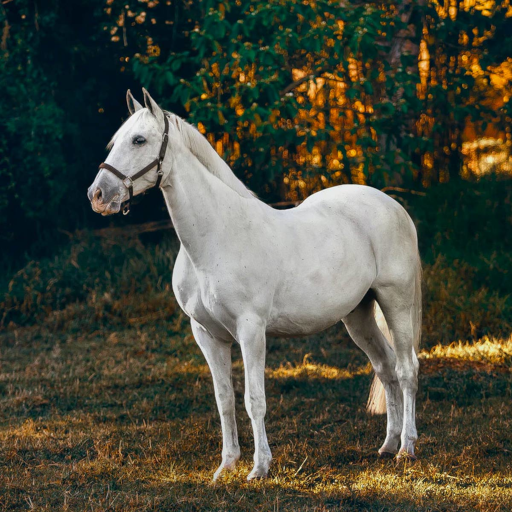

In [105]:
init_image

# Build Mask

In [ ]:
def build_mask(init_latent, actual_embedding, target_embedding, strength, n, thresh, scheduler, unet, device='cuda'):
    with torch.no_grad():
        diff_buffer = torch.zeros(1, 4, 64, 64).to(device)
        t_enc = torch.tensor([int(strength * 1000)]).to(device)

        for _ in range(n):
            # add noise to latent
            noise = torch.randn_like(init_latent)
            noisy_latent = scheduler.add_noise(init_latent, noise, t_enc)

            # predict noise with both embeddings and clamp it
            pred_noise_actual = unet(noisy_latent, t_enc, encoder_hidden_states=actual_embedding).sample.clamp(-3.5, 3.5)
            pred_noise_target = unet(noisy_latent, t_enc, encoder_hidden_states=target_embedding).sample.clamp(-3.5, 3.5)

            # work out difference between noises
            noise_diff = pred_noise_target - pred_noise_actual

            # add to total diff tensor
            diff_buffer += noise_diff


        average_diff = diff_buffer / n

        # scale to [0, 1] across all channels
        average_diff_max = average_diff.max()
        average_diff_min = average_diff.min()

        # scale to [0, 1] within each channel
        # average_diff_max = average_diff.reshape((4,4096)).max(1).values.reshape((1,4,1,1))
        # average_diff_min = average_diff.reshape((4,4096)).min(1).values.reshape((1,4,1,1))

        average_diff = (average_diff - average_diff_min) / (average_diff_max - average_diff_min)

        # apply threshold
        mask = (average_diff > thresh)

        return mask

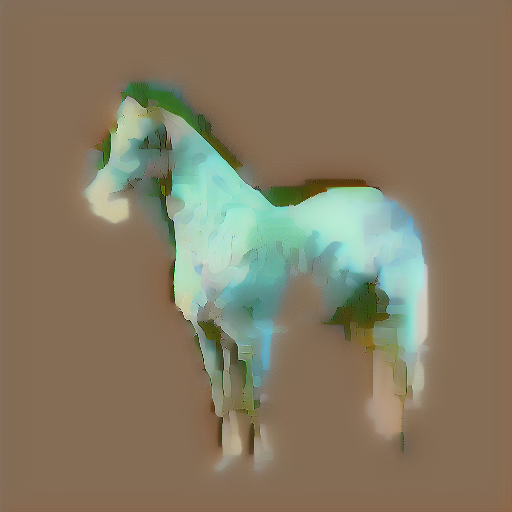

In [76]:
latent_mask = build_mask(init_latent, emb_actual, emb_target, 0.65, 50, 0.52, pipe.scheduler, pipe.unet)
latents_to_pil(latent_mask.float(), pipe.vae)[0]

In [77]:
mask_array = latent_mask.max(1).values.detach().cpu().reshape(64,64).numpy()
mask = Image.fromarray(mask_array).resize((512, 512))
mask_inv = Image.fromarray(~mask_array).resize((512, 512))

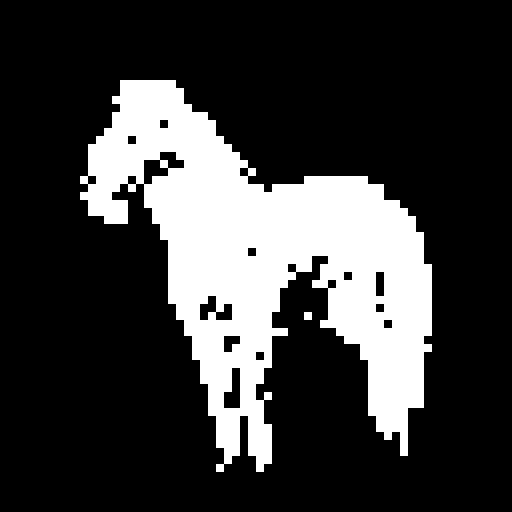

In [78]:
mask

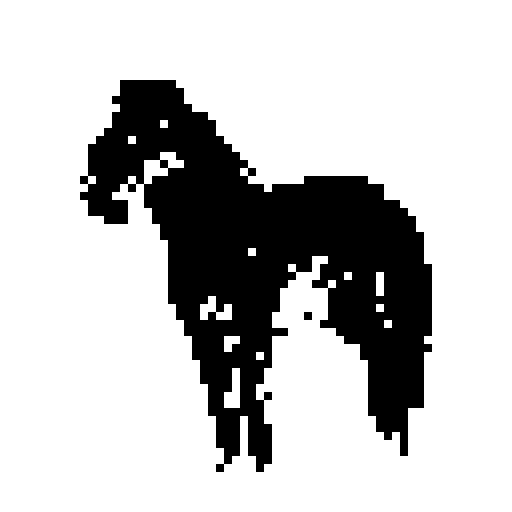

In [79]:
mask_inv

# Do inpainting using generated mask

  0%|          | 0/50 [00:00<?, ?it/s]

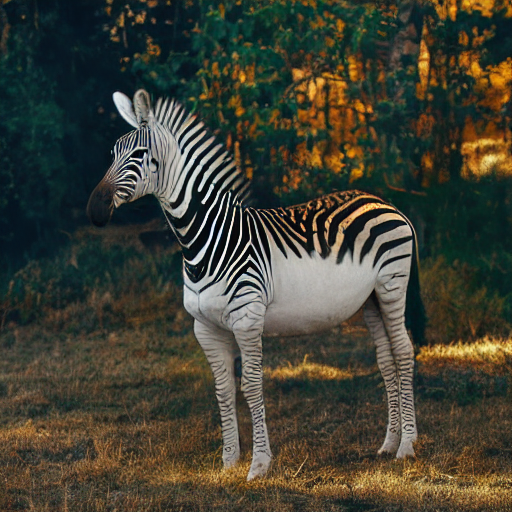

In [45]:
image = im2im_pipe(
    prompt=prompt_target,
    image=init_image,
    mask_image=mask,
    num_inference_steps=50,
    guidance_scale=7.5,
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

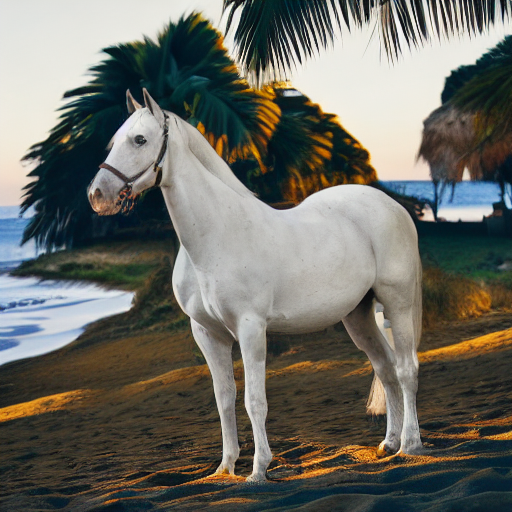

In [104]:
image = im2im_pipe(
    prompt="a detailed photo of a white horse standing on the beach, award winning",
    image=init_image,
    mask_image=mask_inv,
    num_inference_steps=50,
    guidance_scale=10,
    # negative_prompt="grass, trees",
).images[0]
image